In [2]:
# Import file reading and image packages
import os
import json
from PIL import Image
from PIL import ImageOps
import requests
from io import BytesIO
import matplotlib.pyplot as plt

In [3]:
# Import array and ML packages
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from keras.datasets import fashion_mnist
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator

In [4]:
# Connect to Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read photo url file
# Store into dictionary where key is the photo id and value is the url
dir_name = '/content/drive/My Drive/CS 230 '
url_dict = {}
with open(os.path.join(dir_name, 'photos.txt')) as f:
    for line in f:
        cur_line = line.split(",")
        url_dict[int(cur_line[0])] = cur_line[1][:-1]

In [ ]:
# Function for producing input output pairs for a given category
# For each street image, it gets the shop image with the corresponding id. If
# the url is inaccessible, the pair is skipped.
def extract_pairs(dir_name, category, set_type):
    print(category + set_type)
    with open(os.path.join(dir_name, set_type + '_pairs_' + category + '.json')) as f:
        street_list = json.load(f)

    with open(os.path.join(dir_name, 'retrieval_' + category + '.json')) as f:
        product_list = json.load(f)

    product_dict = {}
    for pair in product_list:
        product_dict[pair['product']] = pair['photo']
    
    image_dir = '/content/drive/My Drive/CS 230 /images/' + category + '/' + set_type
    os.chdir(image_dir)
    pair_list = []
    counter = 0
    error_counter = 0
    for info in street_list:
        counter += 1
        if counter % 200 == 0:
            print(counter)
        photo_id = info['photo']
        user_image_response = requests.get(url_dict[photo_id])
        try:
            user_image = Image.open(BytesIO(user_image_response.content))
        except:
            error_counter += 1
            continue
        box = info['bbox']
        cropped_user_image = user_image.crop((box['left'], box['top'], box['left'] + box['width'], box['top'] + box['height']))
        shop_image_id = product_dict[info['product']]
        shop_image_response = requests.get(url_dict[shop_image_id])
        try:
            shop_image = Image.open(BytesIO(shop_image_response.content))
            cropped_user_image.save(image_dir + '/' + "input_" + str(counter - error_counter) + '.jpeg')
            shop_image.save(image_dir + '/' + "output_" + str(counter - error_counter) + '.jpeg')
        except: 
            error_counter += 1
    print("final:")
    print(counter)
  

In [ ]:
# Produce input output pairs for each category, save on drive
json_dir_name = 'drive/My Drive/CS 230 /json'
category_list = ['bags','belts','dresses','eyewear','footwear','hats','leggings','outerwear','pants','skirts','tops']

for category in category_list:
    extract_pairs(json_dir_name,category,'train')
    extract_pairs(json_dir_name,category,'test')

In [ ]:
# Loops through images in drive to produce input/output pairs where
# the input is an image of an article of clothing and the output is the type of
# clothing
def process_data(category, set_type, width, height):
    dir = '/content/drive/My Drive/CS 230 /images/' + category + '/' + set_type
    os.chdir(dir)
    image_list = []
    for image_name in os.listdir():
        if image_name[0] == 'i':
            resized_image = Image.open(image_name).resize((width, height))
            grayscale = ImageOps.grayscale(resized_image)
            image_array = np.asarray(grayscale)
            image_list.append(image_array)
    X = np.asarray(image_list)
    Y = np.asarray([category for i in range(len(X))])
    return (X, Y)

In [ ]:
# Produces input output pairs for all categories
width = 64
height = 64
train_X = [0]
train_Y = [0]
test_X = [0]
test_Y = [0]
category_list = ['belts','eyewear','bags','footwear','hats','leggings','outerwear','pants','tops','dresses','skirts']

for category in category_list:
    cur_train = process_data(category, 'train', width, height)
    cur_test = process_data(category, 'test', width, height)
    if len(train_X) == 1:
        train_X = cur_train[0]
        train_Y = cur_train[1]
        test_X = cur_test[0]
        test_Y = cur_test[1]
    else:
        train_X = np.concatenate((train_X, cur_train[0]))
        train_Y = np.concatenate((train_Y, cur_train[1]))
        test_X = np.concatenate((test_X, cur_test[0]))
        test_Y = np.concatenate((test_Y, cur_test[1]))
    print("Category complete\n")
    print("Train size: " + str(len(train_X)) + '\n')
    print("Test size: " + str(len(test_X)) + '\n')

Category complete

Train size: 20592

Test size: 6088

Category complete

Train size: 22603

Test size: 6480



In [ ]:
# Save data
os.chdir('/content/drive/My Drive/CS 230 /classification_model_data')
train_X_reshaped = train_X.reshape(train_X.shape[0], -1)
test_X_reshaped = test_X.reshape(test_X.shape[0], -1)
train_X_shape = train_X.shape
test_X_shape = test_X.shape
np.savetxt("train_X_reshaped.csv",train_X_reshaped)
np.savetxt("test_X_reshaped.csv",test_X_reshaped)
np.savetxt("train_Y.csv",train_Y, fmt = "%s")
np.savetxt("test_Y.csv", test_Y, fmt = "%s")


In [5]:
# Load data from drive
os.chdir('/content/drive/My Drive/CS 230 /classification_model_data_64')
train_X_reshaped = np.loadtxt("train_X_reshaped.csv")
test_X_reshaped = np.loadtxt("test_X_reshaped.csv")
train_Y = np.loadtxt("train_Y.csv", dtype = 'str')
test_Y = np.loadtxt("test_Y.csv", dtype = 'str')

In [6]:
# Number of training examples:
# - bags: 444, belts: 140, eyewear 147, footwear 5342, hats 290, leggings 1348, outerwear 811, pants 411, tops 1799, dresses 10148, skirts 2011
# Eliminate unwanted categories
i = 0
while(i != len(train_Y)):
    if train_Y[i] != 'footwear' and train_Y[i] != 'leggings' and train_Y[i] != 'pants' and train_Y[i] != 'tops' and train_Y[i] != 'dresses' and train_Y[i] != 'skirts':
        train_Y = np.delete(train_Y, i)
        train_X_reshaped = np.delete(train_X_reshaped, i, axis = 0)
    else:
        i += 1

i = 0
test_length = len(test_Y)
while(i != len(test_Y)):
    if test_Y[i] != 'footwear' and test_Y[i] != 'leggings' and test_Y[i] != 'pants' and test_Y[i] != 'tops' and test_Y[i] != 'dresses' and test_Y[i] != 'skirts':
        test_Y = np.delete(test_Y, i)
        test_X_reshaped = np.delete(test_X_reshaped, i, axis = 0)
    else:
        i += 1

In [7]:
# Reformat input data into 4D
width = 64
height = 64
train_X = train_X_reshaped.reshape((train_X_reshaped.shape[0],width,height)).reshape(-1, width,  height, 1)
test_X = test_X_reshaped.reshape((test_X_reshaped.shape[0],width,height)).reshape(-1, width, height, 1)

In [8]:
# Convert string category labels to numbers 0 through 10
# Initially we used the encoding commented below, then we reduced the number of classes
#encoding = {'belts': 0,'eyewear': 1,'bags': 2,'footwear': 3,'hats': 4,'leggings': 5,'outerwear': 6,'pants': 7,'tops': 8,'dresses': 9,'skirts': 10}
encoding = {"footwear":0,"pants":1,"leggings":1, "tops":2,"dresses":3,"skirts":4}

train_Y_encoded = np.zeros(train_Y.shape)
for i in range(len(train_Y)):
    train_Y_encoded[i] = encoding[train_Y[i]]

test_Y_encoded = np.zeros(test_Y.shape)
for i in range(len(test_Y)):
    test_Y_encoded[i] = encoding[test_Y[i]]

In [9]:
# preprocess and shuffle training set

num_classes = 5

np.random.seed(230)

rng_state = np.random.get_state()
train_X_shuffled = train_X.copy()/255.
np.random.shuffle(train_X_shuffled)
train_Y_categorical = to_categorical(train_Y_encoded, num_classes = num_classes) # one hot encoding
np.random.set_state(rng_state)
train_Y_shuffled = train_Y_categorical.copy()
np.random.shuffle(train_Y_shuffled)

# Shuffle and create validation and test sets
rng_state = np.random.get_state()
test_X_shuffled = test_X.copy()/255.
np.random.shuffle(test_X_shuffled)
test_Y_categorical = to_categorical(test_Y_encoded, num_classes = num_classes)
np.random.set_state(rng_state)
test_Y_shuffled = test_Y_categorical.copy()
np.random.shuffle(test_Y_shuffled)

midpoint = int(len(test_X_shuffled)/2)
valid_X = test_X_shuffled[0:midpoint]
valid_Y = test_Y_shuffled[0:midpoint]
test_X = test_X_shuffled[midpoint:]
test_Y = test_Y_shuffled[midpoint:]

In [ ]:
# Set up and compile Keras model (model version for 28*28 input)
batch_size = 32
num_classes = 11
epochs = 20

category_class_model = Sequential()
category_class_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding='same',input_shape=(28,28,1)))
category_class_model.add(MaxPooling2D((2, 2),padding='same'))
category_class_model.add(Dropout(0.25))
category_class_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
category_class_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
category_class_model.add(Dropout(0.25))
category_class_model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))         
category_class_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
category_class_model.add(Dropout(0.4))
category_class_model.add(Flatten())
category_class_model.add(Dense(128, activation='relu'))     
category_class_model.add(Dropout(0.3))
category_class_model.add(Dense(num_classes, activation='softmax'))
category_class_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),
                             metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2)])
category_class_model.summary()

In [ ]:
# Set up and compile Keras model (model version for 64*64 input)
batch_size = 64
num_classes = 5
epochs = 50

category_class_model = Sequential()
category_class_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding='same',input_shape=(64,64,1)))
category_class_model.add(MaxPooling2D((2, 2),padding='same'))
category_class_model.add(Dropout(0.3))
category_class_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
category_class_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
category_class_model.add(Dropout(0.3))
category_class_model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))         
category_class_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
category_class_model.add(Dropout(0.4))
category_class_model.add(Conv2D(256, (3, 3), activation='relu',padding='same'))         
category_class_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
category_class_model.add(Dropout(0.4))
category_class_model.add(Flatten())
category_class_model.add(Dense(256, activation='relu'))     
category_class_model.add(Dropout(0.3))
category_class_model.add(Dense(num_classes, activation='softmax'))

category_class_model.summary()
category_class_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2)])



In [ ]:
# train model
category_class_model.fit(train_X_shuffled, train_Y_shuffled, batch_size=batch_size,epochs=epochs,verbose=1)

In [ ]:
test_eval = category_class_model.evaluate(test_X, test_Y, verbose=1)

# validation data loss and validation data accuracy
print(test_eval)

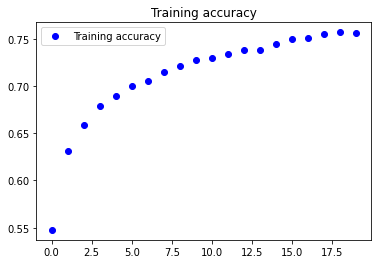

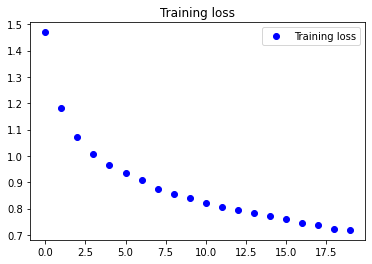

In [ ]:
# Plot graph b/w accuracy and loss on training and validation dataset

accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.title('Training accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()